In [135]:
from datasets import load_dataset
from huggingface_hub import login
import tiktoken
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [136]:
def evaluate_and_characterize_failures(trajectory, target, nums, tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")) -> dict:
    """
    Evaluates a countdown task trajectory and returns detailed diagnosis information
    for all error types, plus equation statistics.
    
    Args:
        trajectory (str): The reasoning trajectory text
        target (int/float): The target number to reach
        nums (list): List of starting numbers available
    
    Returns:
        dict: Results containing:
            - is_valid (bool): Whether the trajectory is correct
            - arithmetic_error (bool): True if there are arithmetic errors
            - invalid_number_usage (bool): True if using numbers not in initial set
            - formatting_issues (bool): True if there are formatting problems
            - total_equations (int): Total number of equations found in the trajectory
            - arithmetic_error_count (int): Number of equations with arithmetic errors
            - token_count (int): Number of tokens in trajectory
    """
    import re
    import ast
    import math
    from typing import List

    # Initialize error flags
    is_valid = True
    arithmetic_error = False
    invalid_number_usage = False
    formatting_issues = False
    token_count = len(tokenizer(trajectory)["input_ids"])
    
    # Initialize equation counters
    total_equations = 0
    arithmetic_error_count = 0
    
    # Enhanced pattern to capture both "=" and "is" as equation separators with flexible spacing
    equation_pattern = re.compile(r"([\d.]+)\s*([\+\-\*/])\s*([\d.]+)\s*(?:=|is)\s*([\d.]+)")
    all_equations = equation_pattern.findall(trajectory)
    
    total_equations = len(all_equations)
    
    # Check each equation for arithmetic correctness
    for eq in all_equations:
        try:
            num1 = float(eq[0])
            op = eq[1]
            num2 = float(eq[2])
            result = float(eq[3])
            
            # Calculate the expected result
            if op == '+':
                expected = num1 + num2
            elif op == '-':
                expected = num1 - num2
            elif op == '*':
                expected = num1 * num2
            elif op == '/':
                if math.isclose(num2, 0.0):
                    arithmetic_error_count += 1
                    continue
                expected = num1 / num2
            else:
                # Invalid operator
                continue
                
            # Compare expected vs. given result
            if not math.isclose(expected, result, rel_tol=1e-5):
                arithmetic_error_count += 1
                
        except Exception:
            # Skip equations with parsing issues
            continue
    
    # Check for incomplete trajectory
    if not re.search(r"RESULT:", trajectory):
        incomplete_trajectory = True
        is_valid = False
    
    # Check for formatting: SOLUTION field
    sol_match = re.search(r"SOLUTION:\s*(YES|NO)", trajectory, re.IGNORECASE)
    if not sol_match:
        formatting_issues = True
        is_valid = False
    else:
        sol_decl = sol_match.group(1).upper()
        if sol_decl != "YES":
            is_valid = False
    
    # Extract OPERATIONS list
    operations = []
    ops_match = re.search(r"OPERATIONS:\s*(\[[^\]]*\])", trajectory, re.DOTALL)
    if not ops_match:
        formatting_issues = True
        is_valid = False
    else:
        try:
            operations = ast.literal_eval(ops_match.group(1))
            if not isinstance(operations, list):
                formatting_issues = True
                is_valid = False
        except Exception:
            formatting_issues = True
            is_valid = False
    
    # Extract final RESULT
    expected_final = None
    res_match = re.search(r"RESULT:\s*([-+.\d]+)", trajectory)
    if not res_match:
        formatting_issues = True
        is_valid = False
    else:
        try:
            expected_final = float(res_match.group(1))
        except Exception:
            formatting_issues = True
            is_valid = False
    
    # If we have severe formatting issues, we can't proceed with arithmetic and usage checks
    if formatting_issues or not operations:
        return {
            "is_valid": is_valid,
            "arithmetic_error": arithmetic_error,
            "invalid_number_usage": invalid_number_usage,
            "formatting_issues": formatting_issues,
            "total_equations": total_equations,
            "arithmetic_error_count": arithmetic_error_count,
            "token_count":token_count
        }
    
    # Simulation: available numbers (as floats)
    available = [float(n) for n in nums]
    
    # Enhanced operation pattern for validation
    op_pattern = re.compile(r"^\s*([\d.]+)\s*([\+\-\*/])\s*([\d.]+)\s*(?:=|is)\s*([\d.]+)\s*$")
    
    operation_results = []  # Store results to check if all numbers were used
    
    for op_str in operations:
        m = op_pattern.match(op_str)
        if not m:
            formatting_issues = True
            is_valid = False
            continue
        
        op1_str, operator, op2_str, given_result_str = m.groups()
        try:
            op1 = float(op1_str)
            op2 = float(op2_str)
            op_result = float(given_result_str)
        except Exception:
            formatting_issues = True
            is_valid = False
            continue
        
        # Check arithmetic correctness
        try:
            if operator == '+':
                computed = op1 + op2
            elif operator == '-':
                computed = op1 - op2
            elif operator == '*':
                computed = op1 * op2
            elif operator == '/':
                if math.isclose(op2, 0.0):
                    arithmetic_error = True
                    is_valid = False
                    continue
                computed = op1 / op2
            else:
                formatting_issues = True
                is_valid = False
                continue
                
            if not math.isclose(computed, op_result, rel_tol=1e-5):
                arithmetic_error = True
                is_valid = False
        except Exception:
            arithmetic_error = True
            is_valid = False
            continue
        
        operation_results.append((op1, op2, op_result))
    
    # Check for invalid number usage by simulating all operations
    if operation_results:
        try:
            # Reset available numbers for a fresh check
            available = [float(n) for n in nums]
            
            def consume(value, pool):
                for i, num in enumerate(pool):
                    if math.isclose(num, value, rel_tol=1e-5):
                        del pool[i]
                        return True
                return False
            
            for op1, op2, result in operation_results:
                if not consume(op1, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                if not consume(op2, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                available.append(result)
            
            # After all operations, should have exactly one number equal to target
            if len(available) != 1:
                invalid_number_usage = True
                is_valid = False
            elif expected_final is not None and not math.isclose(available[0], float(target), rel_tol=1e-5):
                arithmetic_error = True
                is_valid = False
                
        except Exception:
            invalid_number_usage = True
            is_valid = False
    
    return {
        "is_valid": is_valid,
        "arithmetic_error": arithmetic_error,
        "invalid_number_usage": invalid_number_usage, 
        "formatting_issues": formatting_issues,
        "total_equations": total_equations,
        "arithmetic_error_count": arithmetic_error_count,
        "token_count":token_count
    }

In [137]:
from glob import glob
import os 
import json 
import re 

def parse_model_filepath(filepath):
    """
    Parse a model filepath to extract model size, dataset type, context length, and dataset size.
    
    Args:
        filepath (str): Path to the model file
        
    Returns:
        dict: Dictionary containing model_size, dataset_type, context_length, and dataset_size
    """
    # Extract the directory part of the path
    directory = os.path.dirname(filepath)
    # Get the last part of the directory path (the model folder name)
    model_folder = os.path.basename(directory)
    
    # Initialize result dictionary
    result = {
        "model_size": None,
        "dataset_type": None,
        "context_length": None,
        "dataset_size": None
    }
    
    # Extract model size (e.g., 0.5B, 1.5B)
    model_size_match = re.search(r'(\d+\.\d+B)', model_folder)
    if model_size_match:
        result["model_size"] = model_size_match.group(1)
    
    # Extract dataset type (e.g., o3, search, search-react)
    # We need to handle special cases like "search-react" and "search-long"
    if "search-react" in model_folder:
        result["dataset_type"] = "search-react"
    elif "search-long" in model_folder:
        result["dataset_type"] = "search-long"
    elif "search" in model_folder:
        result["dataset_type"] = "search"
    elif "optimal" in model_folder:
        result["dataset_type"] = "optimal"
    elif "o3" in model_folder:
        result["dataset_type"] = "o3"
    
    # Extract context length (e.g., 8k from seq8k)
    context_match = re.search(r'seq(\d+k)', model_folder)
    if context_match:
        result["context_length"] = context_match.group(1)
    
    # Extract dataset size (e.g., 1k, 5k)
    # This is typically the last part of the model folder name
    dataset_size_match = re.search(r'(\d+k)(?:/|$)', model_folder)
    if dataset_size_match:
        result["dataset_size"] = dataset_size_match.group(1)
    
    return result

def find_experiment_files(base_dir, pattern="**/test_128*.json"):
    """Find all experiment result files in the given directory."""
    return glob(os.path.join(base_dir, pattern), recursive=True)

def process_json_files(base_dir):
    # Find all test_*.json files
    test_files = find_experiment_files(base_dir)
    
    results = []
    
    for file_path in test_files:
        filename = os.path.basename(file_path)
        
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Skip the first two elements as per requirements
            if len(data) <= 2:
                print(f"Warning: {filename} has fewer than 3 elements. Skipping.")
                continue
                
            trajectories = data[2:]  # Start from the 3rd element
            
            total_rows = len(trajectories)
            total_is_valid = 0
            total_has_arithmetic_error = 0
            total_has_invalid_number = 0
            total_incomplete_trajectory = 0
            total_has_formatting_issues = 0
            
            arithmetic_error_percentages = []
            token_counts = []
            
            for row in trajectories:
                # Evaluate each trajectory
                evaluation = evaluate_and_characterize_failures(
                    row["completion"], 
                    row["target"], 
                    row["nums"]
                )
                
                # Count the failures
                if evaluation["is_valid"]:
                    total_is_valid += 1
                if evaluation["arithmetic_error"]:
                    total_has_arithmetic_error += 1
                if evaluation["invalid_number_usage"]:
                    total_has_invalid_number += 1
                if evaluation["incomplete_trajectory"]:
                    total_incomplete_trajectory += 1
                if evaluation["formatting_issues"]:
                    total_has_formatting_issues += 1
                
                # Calculate arithmetic error percentage for this trajectory
                if evaluation["total_equations"] > 0:
                    error_percentage = evaluation["arithmetic_error_count"] / evaluation["total_equations"]
                    arithmetic_error_percentages.append(error_percentage)
                    
                if evaluation["token_count"]:
                    token_counts.append(evaluation["token_count"])
            
            # Calculate mean percentage of arithmetic errors
            mean_percentage_arithmetic_error = 0
            if arithmetic_error_percentages:
                mean_percentage_arithmetic_error = sum(arithmetic_error_percentages) / len(arithmetic_error_percentages)
            
            model_train_info = parse_model_filepath(file_path)
            model_train_info.update({
                "total_rows": total_rows,
                "perc_success": total_is_valid/total_rows,
                "perc_arithmetic_error": total_has_arithmetic_error/total_rows,
                "perc_invalid_number": total_has_invalid_number/total_rows,
                "perc_incomplete_trajectory": total_incomplete_trajectory/total_rows,
                "perc_formatting_issues": total_has_formatting_issues/total_rows,
                "mean_percentage_arithmetic_error": mean_percentage_arithmetic_error,
                "p25_token_count":np.percentile(token_counts, 25),
                "p75_token_count":np.percentile(token_counts, 75),
                "max_token_count":np.max(token_counts)
            })
            # Store results for this file
            results.append(
                model_train_info
                )
            
            print(f"Processed {filename}: {total_rows} trajectories")
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    
    return df


def process_json_files(base_dir):
    # Find all test_*.json files
    test_files = find_experiment_files(base_dir)
    
    results = []
    
    for file_path in tqdm(test_files):
        filename = os.path.basename(file_path)
        
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Skip the first two elements as per requirements
            if len(data) <= 2:
                print(f"Warning: {filename} has fewer than 3 elements. Skipping.")
                continue
                
            trajectories = data[2:]  # Start from the 3rd element
            
            total_rows = len(trajectories)
            total_is_valid = 0
            total_has_arithmetic_error = 0
            total_has_invalid_number = 0
            total_incomplete_trajectory = 0
            total_has_formatting_issues = 0
            
            arithmetic_error_percentages = []
            token_counts = []
            
            trajectories_results = []
            
            for row in trajectories:
                # Evaluate each trajectory
                trajectories_results.append(evaluate_and_characterize_failures(
                    row["completion"], 
                    row["target"], 
                    row["nums"]
                ))
            trajectories_results = pd.DataFrame(trajectories_results)
            max_tokens = trajectories_results["token_count"].max()
            total_rows = len(trajectories_results)
            
            # Get counts of various issues
            total_is_valid = trajectories_results["is_valid"].sum()
            total_has_arithmetic_error = trajectories_results["arithmetic_error"].sum()
            total_has_invalid_number = trajectories_results["invalid_number_usage"].sum()
            total_has_formatting_issues = trajectories_results["formatting_issues"].sum()

            # Calculate incomplete trajectories (formatting issues + max token count)
            # We need to check if there are at least 2 trajectories with max token count
            max_token_count_occurrences = (trajectories_results["token_count"] == max_tokens).sum()
            total_has_formatting_issues_and_reach_max_tokens = 0

            if max_token_count_occurrences >= 2:
                # Only count incomplete trajectories if we have at least 2 trajectories with max token count
                total_has_formatting_issues_and_reach_max_tokens = ((trajectories_results["formatting_issues"]) & 
                                                                (trajectories_results["token_count"] == max_tokens)).sum()
                total_has_formatting_issues = ((trajectories_results["formatting_issues"]) & 
                                                    (trajectories_results["token_count"] != max_tokens)).sum()

            # Calculate percentage of arithmetic errors per trajectory
            for _, row in trajectories_results.iterrows():
                if row["total_equations"] > 0:
                    error_percentage = row["arithmetic_error_count"] / row["total_equations"]
                    arithmetic_error_percentages.append(error_percentage)
                else:
                    # If no equations in trajectory, count as 0% error
                    arithmetic_error_percentages.append(0.0)

            # Collect all token counts
            token_counts = trajectories_results["token_count"].tolist()
            
            
            # Calculate mean percentage of arithmetic errors
            mean_percentage_arithmetic_error = 0
            if arithmetic_error_percentages:
                mean_percentage_arithmetic_error = sum(arithmetic_error_percentages) / len(arithmetic_error_percentages)
            
            model_train_info = parse_model_filepath(file_path)
            model_train_info.update({
                "total_rows": total_rows,
                "perc_success": total_is_valid/total_rows,
                "perc_failed_by_arithmetic_errors_in_answer": total_has_arithmetic_error/total_rows,
                "perc_failed_by_using_invalid_numbers": total_has_invalid_number/total_rows,
                "perc_failed_by_incomplete_trajectories": total_has_formatting_issues_and_reach_max_tokens/total_rows,
                "perc_failed_by_formatting_issues": total_has_formatting_issues/total_rows,
                "mean_perc_arithmetic_errors_in_full_trajectory": mean_percentage_arithmetic_error,
                "max_token_count_occurrences": max_token_count_occurrences/total_rows,
                "max_tokens": max_tokens
            })
            # Store results for this file
            results.append(
                model_train_info
                )
            
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    
    return df

In [138]:
df = process_json_files("results copy")

100%|██████████| 21/21 [00:08<00:00,  2.52it/s]


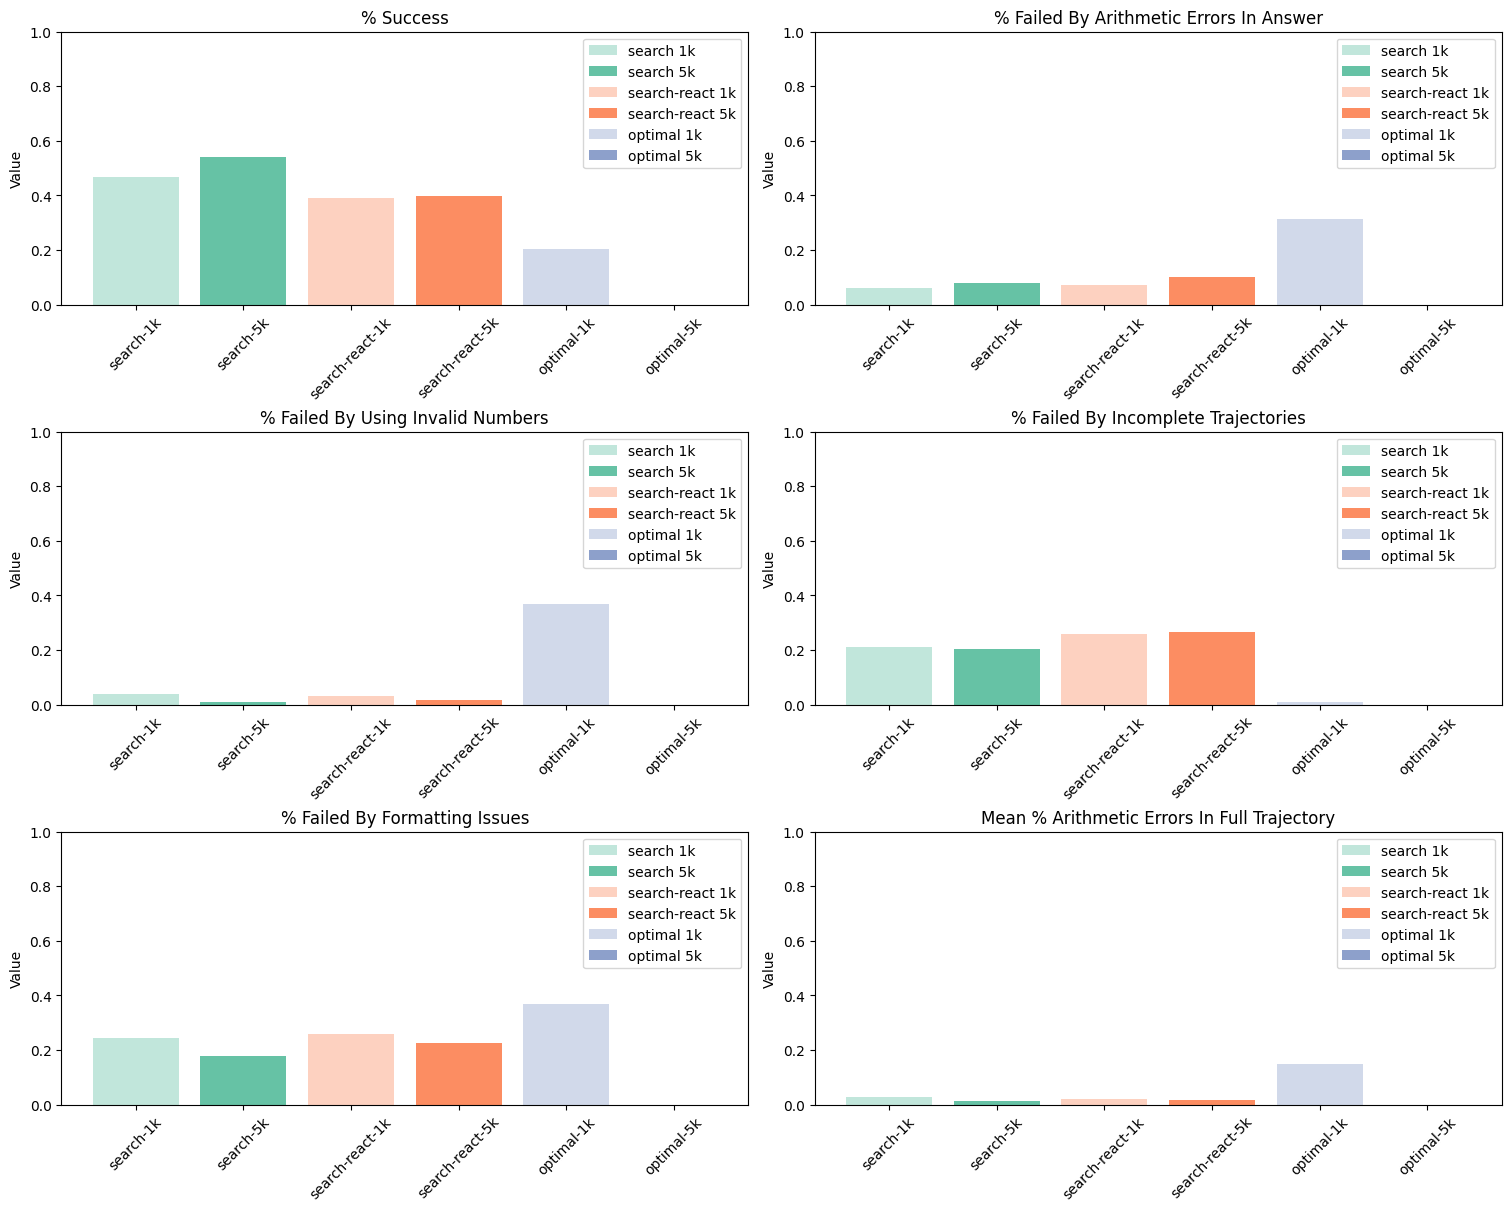

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df[(df['model_size'] == '1.5B') & (df['dataset_type'].isin(["optimal","search","search-react"])) & (df['context_length'] != "8k")]


# Select only the metric columns
metric_cols = [
    'perc_success',
    'perc_failed_by_arithmetic_errors_in_answer',
    'perc_failed_by_using_invalid_numbers',
    'perc_failed_by_incomplete_trajectories',
    'perc_failed_by_formatting_issues',
    'mean_perc_arithmetic_errors_in_full_trajectory',
    # 'max_token_count_occurrences',
]

# Custom color palette: assign base colors to dataset_types
base_palette = sns.color_palette("Set2", n_colors=df_filtered['dataset_type'].nunique())
dataset_types = df_filtered['dataset_type'].unique()
color_mapping = {dtype: base_palette[i] for i, dtype in enumerate(dataset_types)}

# Plot
n_metrics = len(metric_cols)
n_cols = 2
n_rows = (n_metrics + 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), constrained_layout=True)

for i, metric in enumerate(metric_cols):
    ax = axs[i // n_cols, i % n_cols]
    for dtype in dataset_types:
        for size, alpha in zip(['1k', '5k'], [0.4, 1.0]):
            subset = df_filtered[(df_filtered['dataset_type'] == dtype) & (df_filtered['dataset_size'] == size)]
            ax.bar(
                f"{dtype}-{size}",
                subset[metric].values[0] if not subset.empty else 0,
                color=color_mapping[dtype],
                alpha=alpha,
                label=f"{dtype} {size}" if f"{dtype} {size}" not in ax.get_legend_handles_labels()[1] else ""
            )
    ax.set_ylim(0, 1)  # <-- This sets the y-axis range
    ax.set_title(metric.title().replace("_"," ").replace("Perc","%"))
    ax.set_ylabel("Value")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# plt.suptitle("Metrics for model_size = 1.5B", fontsize=16)
plt.show()


In [140]:
for metric in metric_cols:
    fig, ax = plt.subplots(figsize=(8, 5))

    for dtype in dataset_types:
        for size, alpha in zip(['1k', '5k'], [0.4, 1.0]):
            label = f"{dtype}-{size}"
            subset = df_filtered[(df_filtered['dataset_type'] == dtype) & (df_filtered['dataset_size'] == size)]

            value = subset[metric].values[0] if not subset.empty else 0
            bar = ax.bar(
                label,
                value,
                color=color_mapping[dtype],
                alpha=alpha,
                label=f"{dtype} {size}" if f"{dtype} {size}" not in ax.get_legend_handles_labels()[1] else ""
            )

            # Annotate the value
            ax.text(
                label,
                value + 0.02,  # slightly above the bar
                f"{value:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )

    ax.set_ylim(0, 1.05)
    ax.set_title(metric.title().replace("_", " ").replace("Perc", "%"))
    ax.set_ylabel("Value")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

    # Save plot
    safe_filename = metric.lower().replace(" ", "_").replace("%", "perc")
    plt.savefig(f"images/{safe_filename}.png", bbox_inches='tight')
    plt.close()

